
# EDA — Consumo de Café y KPIs de Negocio

Este cuaderno realiza:
1. **Limpieza y normalización** de los datos (columnas de años tipo `1990/91` → `year` entero).
2. **Visualizaciones** para negocio (eje X con *todos los años* en 45°, etiquetas de datos).
3. **KPIs**: Ingresos, Costos, Utilidad, Márgenes, CAGR, Participación de mercado.
4. **Tablas** de resumen por país y tipo de café.
5. **Guardado** del dataset limpio para modelado: `data/coffee_clean.csv`.


In [ ]:
# %%
# Configuración e imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.ticker import FuncFormatter

from utils.io import load_coffee_data, load_price_data, merge_coffee_price, save_clean_dataset
from utils.metrics import profit, margin, cagr, market_share

plt.rcParams["figure.figsize"] = (11, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

DATA_CONSUMO = "data/coffee_db.csv"  # ajusta las rutas si lo ejecutas fuera de este entorno
DATA_PRECIOS = "data/precios.csv"
OUT_CLEAN = "data/coffee_clean.csv"

Path("data").mkdir(exist_ok=True)


In [ ]:

# Evita offsets científicos globalmente
plt.rcParams["axes.formatter.useoffset"] = False

def human_format(num, pos=None):
    # M = 1e6, mM = 1e9, B = 1e12
    if num >= 1e12:
        return f"{num/1e12:.1f}B"
    elif num >= 1e9:
        return f"{num/1e9:.1f}mM"
    elif num >= 1e6:
        return f"{num/1e6:.1f}M"
    else:
        return f"{num:.0f}"

def _beautify_axes(ax):
    # Quitar ejes superior y derecho
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # Formato humano en Y (sin ticklabel_format para evitar el error)
    ax.yaxis.set_major_formatter(FuncFormatter(human_format))
    # Ocultar cualquier “offset” que Matplotlib quiera dibujar
    try:
        ax.yaxis.get_offset_text().set_visible(False)
    except Exception:
        pass

def plot_line_with_labels(x, y, title, xlabel, ylabel):
    x_list = list(x)
    y_list = list(y)

    fig, ax = plt.subplots()
    ax.plot(x_list, y_list, marker="o")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Ticks X: todos los años, rotados 45° y alineados
    try:
        years = sorted(set(int(v) for v in x_list))
        ax.set_xticks(years)
    except Exception:
        ax.set_xticks(range(len(x_list)))
        ax.set_xticklabels(x_list)
    ax.tick_params(axis="x", rotation=45)
    for t in ax.get_xticklabels():
        t.set_ha("right")

    # Etiquetas de datos
    for xi, yi in zip(x_list, y_list):
        ax.annotate(human_format(yi), (xi, yi),
                    textcoords="offset points", xytext=(0,6), ha="center")

    _beautify_axes(ax)
    plt.tight_layout()
    plt.show()

def plot_bar_with_labels(x, y, title, xlabel, ylabel):
    x_list = list(x)
    y_list = list(y)

    fig, ax = plt.subplots()
    ax.bar(x_list, y_list)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Rotación y alineación eje X
    ax.tick_params(axis="x", rotation=45)
    for t in ax.get_xticklabels():
        t.set_ha("right")

    # Etiquetas sobre barras
    for xi, yi in zip(x_list, y_list):
        ax.annotate(human_format(yi), (xi, yi),
                    textcoords="offset points", xytext=(0,6), ha="center")

    _beautify_axes(ax)
    plt.tight_layout()
    plt.show()


In [3]:

# %%
# Carga y limpieza
coffee_long = load_coffee_data(DATA_CONSUMO)
price_yearly = load_price_data(DATA_PRECIOS)
df = merge_coffee_price(coffee_long, price_yearly)

# Supuestos de costos (ajustables)
FIXED_COST = 1_000_000.0   # costos fijos anuales globales (USD)
VAR_COST_PER_CUP = 0.05    # costo variable por taza (USD)

df["revenue"] = df["price"] * df["consumption"]
df["profit"] = profit(df["consumption"], df["price"], FIXED_COST/df["year"].nunique(), VAR_COST_PER_CUP)
df["margin"] = margin(df["consumption"], df["price"], FIXED_COST/df["year"].nunique(), VAR_COST_PER_CUP)

# Participación de mercado por año
df = market_share(df, value_col="consumption", group_cols=("year",))

# Guardar dataset limpio
clean_path = save_clean_dataset(df, OUT_CLEAN)
clean_path


/home/wilson/Documentos/Coffee/utils/io.py:135: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
/home/wilson/Documentos/Coffee/utils/io.py:216: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  out["date"] = pd.to_datetime(out["date"], errors="coerce", infer_datetime_format=True)


PosixPath('data/coffee_clean.csv')

In [4]:

# %%
# Tablas de resumen
top_countries = (df.groupby("country", as_index=False)["consumption"]
                   .sum().sort_values("consumption", ascending=False)
                   .head(10))

summary_by_country_type = (df.groupby(["country","type"], as_index=False)
                             .agg(consumption_total=("consumption","sum"),
                                  revenue_total=("revenue","sum"),
                                  profit_total=("profit","sum"),
                                  margin_avg=("margin","mean")))

df.head(3)


,country,type,consumption,year,price,revenue,profit,margin,market_share
0,Angola,Robusta/Arabica,1200000,1991,87.686363,1.052236e+08,1.051303e+08,0.999113,0.001025
1,Angola,Robusta/Arabica,1800000,1992,87.686363,1.578355e+08,1.577121e+08,0.999219,0.001483
2,Angola,Robusta/Arabica,2100000,1993,87.686363,1.841414e+08,1.840030e+08,0.999249,0.001671


In [5]:
top_countries.head(10)

,country,consumption
2,Brazil,27824700000
25,Indonesia,4920480000
16,Ethiopia,4536540000
32,Mexico,3189660000
40,Philippines,2807280000
6,Colombia,2536776384
50,Venezuela,2386067999
24,India,2093460000
51,Viet Nam,1920928320
45,Thailand,1248600000


In [6]:
summary_by_country_type.head(10)

,country,type,consumption_total,revenue_total,profit_total,margin_avg
0,Angola,Robusta/Arabica,46500000,5.367683e+09,5.364358e+09,0.999245
1,Bolivia (Plurinational State of),Arabica,75180000,8.933441e+09,8.928682e+09,0.999371
2,Brazil,Arabica/Robusta,27824700000,3.342971e+12,3.341579e+12,0.999514
3,Burundi,Arabica/Robusta,3412020,3.880223e+08,3.868516e+08,0.996661
4,Cameroon,Robusta/Arabica,143450940,1.614913e+10,1.614096e+10,0.999445
5,Central African Republic,Robusta,24794400,2.912287e+09,2.910047e+09,0.998694
6,Colombia,Arabica,2536776384,2.932195e+11,2.930917e+11,0.999510
7,Congo,Robusta,5360040,6.139875e+08,6.127195e+08,0.997700
8,Costa Rica,Arabica,665335200,7.607959e+10,7.604532e+10,0.999500
9,Cuba,Arabica,384006000,4.419328e+10,4.417308e+10,0.999489


In [7]:
# %%
# Helpers de graficación con etiquetas y ticks anuales rotados 45°
def plot_line_with_labels(x, y, title, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.plot(x, y, marker="o")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # ticks de todos los años
    ax.set_xticks(sorted(df["year"].unique()))
    ax.tick_params(axis="x", rotation=45)
    # etiquetas de datos
    for xi, yi in zip(x, y):
        ax.annotate(f"{yi:,.0f}", (xi, yi), textcoords="offset points", xytext=(0,6), ha="center")
    plt.tight_layout()
    plt.show()

def plot_bar_with_labels(x, y, title, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.bar(x, y)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis="x", rotation=45)
    # etiquetas
    for xi, yi in zip(x, y):
        ax.annotate(f"{yi:,.0f}", (xi, yi), textcoords="offset points", xytext=(0,6), ha="center")
    plt.tight_layout()
    plt.show()


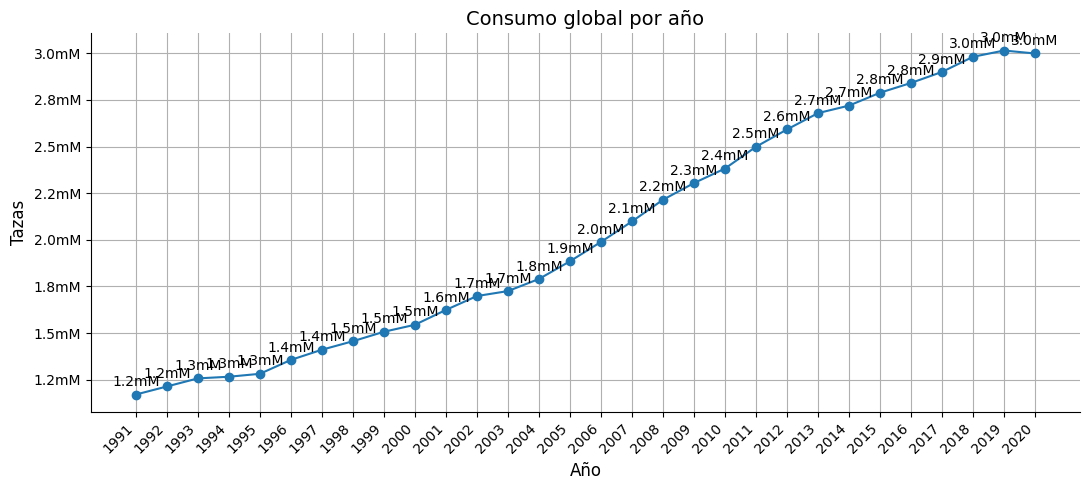

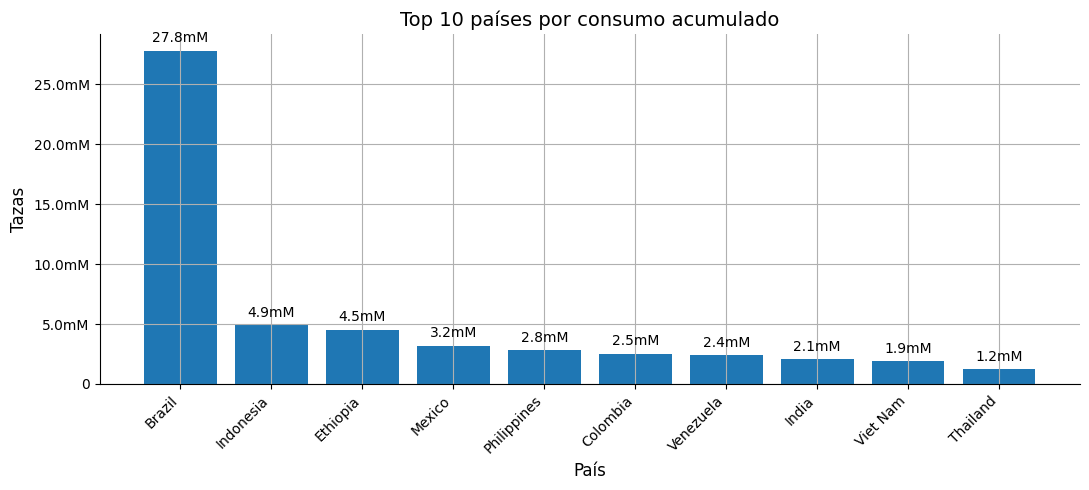

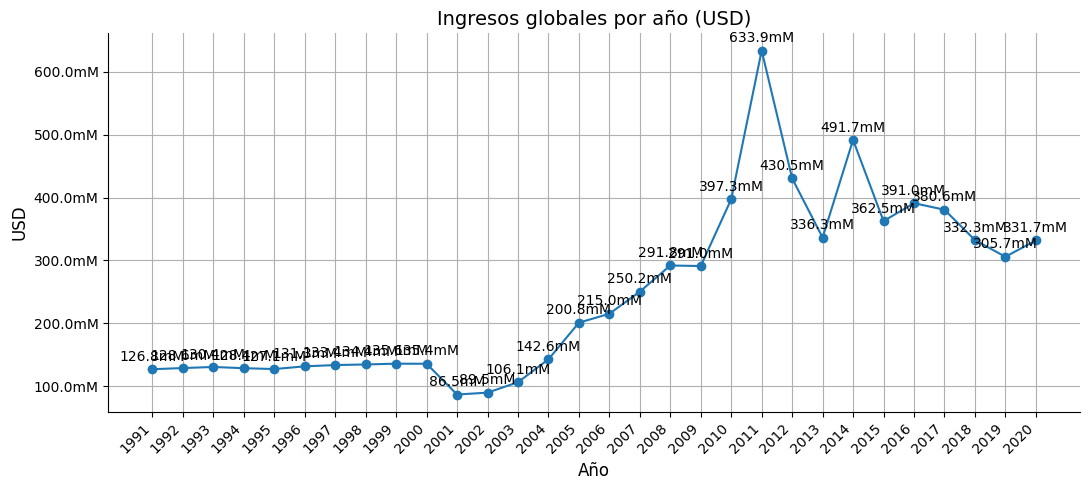

In [12]:
# 1) Consumo global
global_year = df.groupby("year", as_index=False)["consumption"].sum()
plot_line_with_labels(global_year["year"], global_year["consumption"],
                      "Consumo global por año", "Año", "Tazas")

# 2) Top 10 países
plot_bar_with_labels(top_countries["country"], top_countries["consumption"],
                     "Top 10 países por consumo acumulado", "País", "Tazas")

# 3) Ingresos globales
global_rev = df.groupby("year", as_index=False)["revenue"].sum()
plot_line_with_labels(global_rev["year"], global_rev["revenue"],
                      "Ingresos globales por año (USD)", "Año", "USD")


In [69]:
# %%
# KPIs extra: CAGR por país (consumo) entre primer y último año observado
years = (df["year"].min(), df["year"].max())
periods = years[1] - years[0]
country_cagr = []
for c, g in df.groupby("country"):
    g = g.sort_values("year")
    first = g.loc[g["year"].idxmin(), "consumption"]
    last = g.loc[g["year"].idxmax(), "consumption"]
    country_cagr.append({"country": c, "cagr_consumption": cagr(first, last, periods)})
country_cagr = pd.DataFrame(country_cagr).sort_values("cagr_consumption", ascending=False)
country_cagr.head(10)


,country,cagr_consumption
44,Tanzania,0.115416
51,Viet Nam,0.104092
45,Thailand,0.071687
10,Côte d'Ivoire,0.065757
34,Nicaragua,0.064797
40,Philippines,0.053345
25,Indonesia,0.047766
49,Uganda,0.045445
16,Ethiopia,0.040368
2,Brazil,0.034617
